In [1]:
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install imbalanced-learn

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 70.2 MB/s eta 0:00:00a 0:00:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0


# First time: Load and split data

## 1. First Model (Autoencoder)

Load the same split data

Train autoencoder model

Save predictions

## 2. Second Model (Isolation Forest)

Load the same split data

Train Isolation Forest

Save predictions

## 3. Third Model (LocalOutlierFactor)

Load the same split data

Train LOF

Save predictions

## 4. Perform Majority Vote
majority_predictions = framework.majority_vote()

# Evaluate final results
from sklearn.metrics import classification_report
print(classification_report(y_test, majority_predictions))

In [29]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from sklearn.svm import OneClassSVM

In [24]:
# Framework
class FraudDetectionFramework:
    def __init__(self, base_path='./'):
        self.base_path = base_path
        self.data_path = os.path.join(base_path, 'creditcard_2023.csv')
        self.results_path = os.path.join(base_path, 'results')
        
        # Create results directory if it doesn't exist
        if not os.path.exists(self.results_path):
            os.makedirs(self.results_path)
            
    def load_and_split_data(self, random_state=42):
        """Load data and create consistent train-test split"""
        # Load data
        data_df = pd.read_csv(self.data_path)
        
        # Split features and target
        X = data_df.drop('Class', axis=1)
        y = data_df['Class']
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )
        
        # Save split data
        split_data = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
        
        with open(os.path.join(self.results_path, 'split_data.pkl'), 'wb') as f:
            pickle.dump(split_data, f)
            
        return X_train, X_test, y_train, y_test
    
    def load_split_data(self):
        """Load the saved train-test split"""
        with open(os.path.join(self.results_path, 'split_data.pkl'), 'rb') as f:
            split_data = pickle.load(f)
        return (split_data['X_train'], split_data['X_test'], 
                split_data['y_train'], split_data['y_test'])
    
    def save_model_predictions(self, model_name, predictions):
        """Save predictions from a specific model"""
        with open(os.path.join(self.results_path, f'{model_name}_predictions.pkl'), 'wb') as f:
            pickle.dump(predictions, f)
    
    def majority_vote(self):
        """Perform majority voting on all saved model predictions"""
        predictions = []
        
        # Load predictions from each model
        for model_name in ['autoencoder', 'isolation_forest', 'lof']:
            with open(os.path.join(self.results_path, f'{model_name}_predictions.pkl'), 'rb') as f:
                pred = pickle.load(f)
                predictions.append(pred)
        
        # Convert to numpy arrays
        predictions = np.array(predictions)
        
        # Perform majority voting
        majority_pred = (predictions.sum(axis=0) >= 2).astype(int)
        
        return majority_pred

In [10]:
# Initialize framework
framework = FraudDetectionFramework()

# First time: Load and split data
X_train, X_test, y_train, y_test = framework.load_and_split_data()

Epoch 10/100, Loss: 0.7712
Epoch 20/100, Loss: 0.7670
Epoch 30/100, Loss: 0.7654
Epoch 40/100, Loss: 0.7645
Epoch 50/100, Loss: 0.7638
Epoch 60/100, Loss: 0.7635
Epoch 70/100, Loss: 0.7633
Epoch 80/100, Loss: 0.7631
Epoch 90/100, Loss: 0.7630
Epoch 100/100, Loss: 0.7629

Training completed and predictions saved!
Number of predicted frauds: 45490


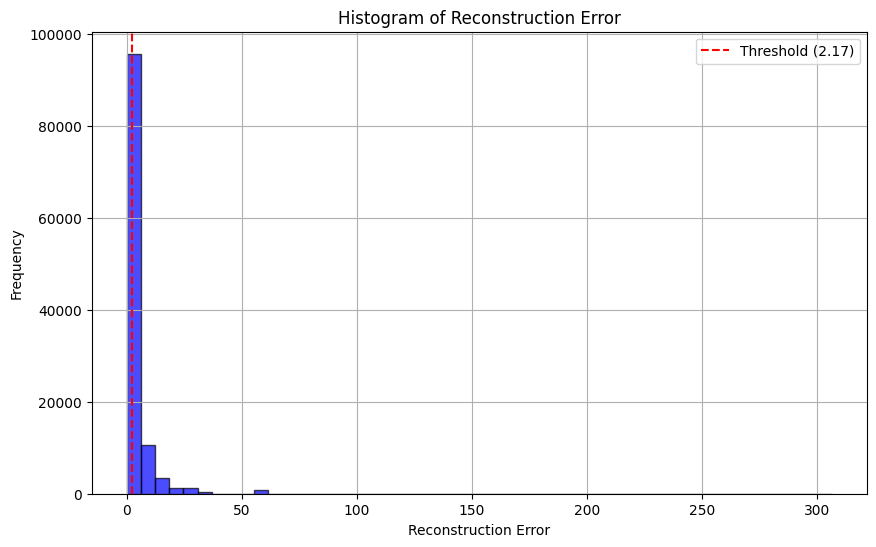

In [ ]:
# train AutoEncoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, int(encoding_dim / 2))
        )
        self.decoder = nn.Sequential(
            nn.Linear(int(encoding_dim / 2), encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder_model():
    # Initialize framework
    framework = FraudDetectionFramework()
    
    # Load the split data
    X_train, X_test, y_train, y_test = framework.load_split_data()
    
    # Additional preprocessing for autoencoder
    # Keep only non-fraud for training
    X_train_nonfraud = X_train[y_train == 0]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_nonfraud)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Initialize model
    input_dim = X_train_scaled.shape[1]
    encoding_dim = 14
    model = Autoencoder(input_dim, encoding_dim)
    
    # Training parameters
    train_loader = DataLoader(TensorDataset(X_train_tensor), 
                            batch_size=64, 
                            shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
    
    # Testing
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_test_tensor)
        reconstruction_errors = torch.mean((reconstructed - X_test_tensor) ** 2, axis=1).numpy()
    
    # Compute threshold and predictions
    threshold = np.percentile(reconstruction_errors, 60)  # Using 60th percentile as threshold
    predictions = (reconstruction_errors > threshold).astype(int)
    
    # Save predictions using framework
    framework.save_model_predictions('autoencoder', predictions)
    
    print("\nTraining completed and predictions saved!")
    print(f"Number of predicted frauds: {sum(predictions)}")
    return model, predictions, reconstruction_errors, threshold

if __name__ == "__main__":
    # Set random seed
    torch.manual_seed(42)
    
    # Train model and get predictions
    model, predictions, reconstruction_errors, threshold = train_autoencoder_model()
    
    # Optional: Plot reconstruction errors
    from matplotlib import pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Reconstruction Error')
    plt.grid(True)
    plt.legend()
    plt.show()

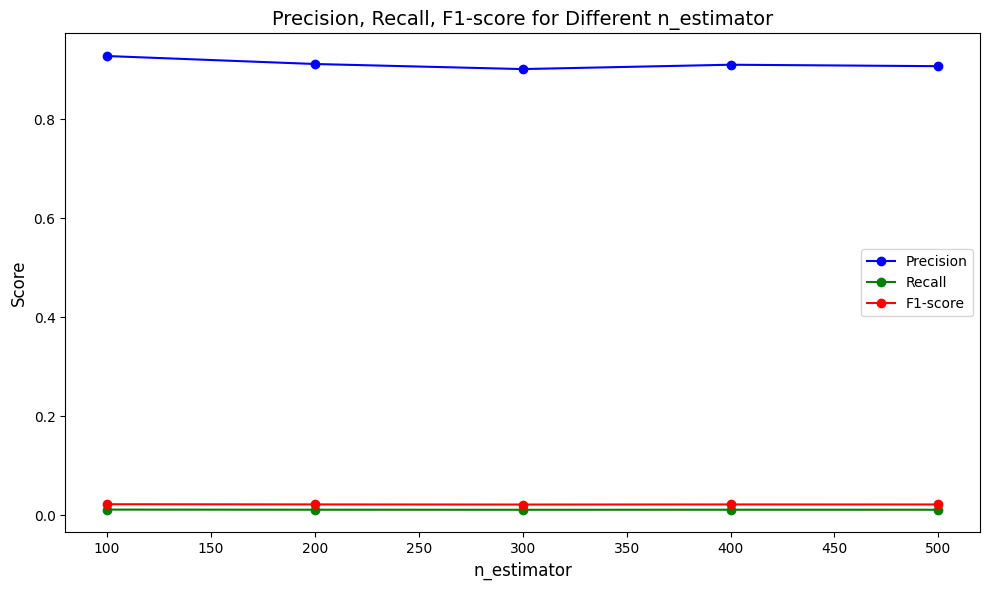


Training completed and predictions saved!
Best model n_estimators: 100
Best model F1-score: 0.0220
Number of predicted frauds: 682

Best Model Performance Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56863
           1       0.93      0.01      0.02     56863

    accuracy                           0.51    113726
   macro avg       0.72      0.51      0.35    113726
weighted avg       0.72      0.51      0.35    113726



In [ ]:
# train IsolationForest
def train_isolation_forest_model():
    # Initialize framework
    framework = FraudDetectionFramework()
    
    # Load the split data
    X_train, X_test, y_train, y_test = framework.load_split_data()
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define hyperparameters
    n_estimator_candidates = [100, 200, 300, 400, 500]
    contamination = 0.006  # Based on your original code
    outlier_ratio_on_test = 0.006  # Based on your original code
    
    # Train and evaluate models
    ifs, confusion_matrices, reports, reports_dicts = train_test_if(
        X_train_scaled, 
        X_test_scaled, 
        y_test, 
        n_estimator_candidates,
        outlier_ratio_on_test,
        contamination
    )
    
    # Find best model based on F1 score
    f1_scores = [report_dict["1"]["f1-score"] for report_dict in reports_dicts]
    best_model_idx = np.argmax(f1_scores)
    best_model = ifs[best_model_idx]
    
    # Get predictions from best model
    test_scores = best_model.decision_function(X_test_scaled)
    sorted_test_scores = np.sort(test_scores)
    threshold_index = int(len(sorted_test_scores) * outlier_ratio_on_test)
    threshold_score = sorted_test_scores[threshold_index]
    predictions = np.where(test_scores < threshold_score, 1, 0)
    
    # Save predictions using framework
    framework.save_model_predictions('isolation_forest', predictions)
    
    # Plot evaluation metrics
    plot_if_evaluations(n_estimator_candidates, reports_dicts)
    
    print("\nTraining completed and predictions saved!")
    print(f"Best model n_estimators: {n_estimator_candidates[best_model_idx]}")
    print(f"Best model F1-score: {f1_scores[best_model_idx]:.4f}")
    print(f"Number of predicted frauds: {sum(predictions)}")
    
    return best_model, predictions, reports[best_model_idx]

def train_test_if(X_train, X_test, y_test, n_estimator_candidates, outlier_ratio_on_test=0.006, contamination=0.006):
    confusion_matrices = []
    reports = []
    reports_dicts = []
    ifs = []

    for n_estimator_candidate in n_estimator_candidates:
        # Fit Isolation Forest Model
        iso_forest = IsolationForest(
            n_estimators=n_estimator_candidate, 
            contamination=contamination,
            random_state=42  # Added for reproducibility
        )
        # Train on train dataset
        iso_forest.fit(X_train)

        # Test on test dataset
        test_scores = iso_forest.decision_function(X_test)
        # Compute threshold based on pre-defined outlier_ratio_on_test
        sorted_test_scores = np.sort(test_scores)
        threshold_index = int(len(sorted_test_scores) * outlier_ratio_on_test)
        threshold_score = sorted_test_scores[threshold_index]
        # 1 means fraud and 0 means not fraud
        y_pred = np.where(test_scores < threshold_score, 1, 0)

        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        reports.append(classification_report(y_test, y_pred))
        reports_dicts.append(classification_report(y_test, y_pred, output_dict=True))
        ifs.append(iso_forest)

    return ifs, confusion_matrices, reports, reports_dicts

def plot_if_evaluations(n_estimator_candidates, reports_dicts):
    if len(reports_dicts) < 1:
        print("No enough n-estimators candidates!")
        return
        
    precision_values = []
    recall_values = []
    f1_score_values = []

    for report_dict in reports_dicts:
        precision_values.append(report_dict["1"]["precision"])
        recall_values.append(report_dict["1"]["recall"])
        f1_score_values.append(report_dict["1"]["f1-score"])

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimator_candidates, precision_values, marker='o', label='Precision', linestyle='-', color='b')
    plt.plot(n_estimator_candidates, recall_values, marker='o', label='Recall', linestyle='-', color='g')
    plt.plot(n_estimator_candidates, f1_score_values, marker='o', label='F1-score', linestyle='-', color='r')

    plt.xlabel('n_estimator', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision, Recall, F1-score for Different n_estimator', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train model and get predictions
    best_model, predictions, best_report = train_isolation_forest_model()
    print("\nBest Model Performance Report:")
    print(best_report)

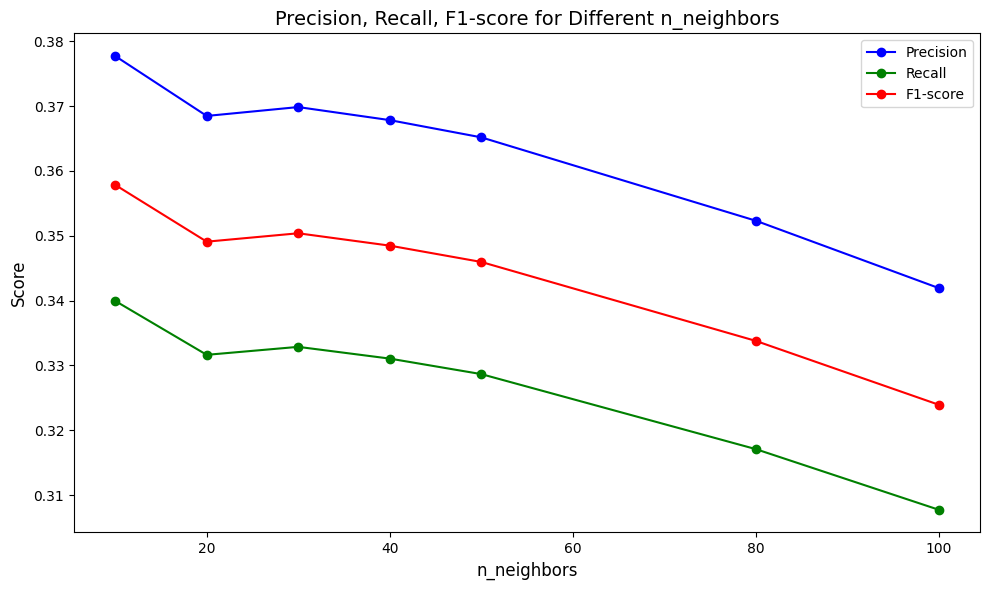


Training completed and predictions saved!
Best model n_neighbors: 10
Best model F1-score: 0.3578
Number of predicted frauds: 51176

Best Model Performance Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42     56863
           1       0.38      0.34      0.36     56863

    accuracy                           0.39    113726
   macro avg       0.39      0.39      0.39    113726
weighted avg       0.39      0.39      0.39    113726



In [ ]:
# train LOF
def train_lof_model():
    # Initialize framework
    framework = FraudDetectionFramework()
    
    # Load the split data
    X_train, X_test, y_train, y_test = framework.load_split_data()
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define hyperparameters
    n_neighbors_candidates = [10, 20, 30, 40, 50, 80, 100]
    contamination = 0.5  # Based on your original code
    outlier_ratio_on_test = 0.45  # Based on your original code
    
    # Train and evaluate models
    lofs, confusion_matrices, reports, reports_dicts = train_multiple_lof_models(
        X_train_scaled, 
        X_test_scaled, 
        y_test, 
        n_neighbors_candidates,
        outlier_ratio_on_test,
        contamination
    )
    
    # Find best model based on F1 score
    f1_scores = [report_dict["1"]["f1-score"] for report_dict in reports_dicts]
    best_model_idx = np.argmax(f1_scores)
    best_model = lofs[best_model_idx]
    
    # Get predictions from best model
    test_scores = best_model.decision_function(X_test_scaled)
    sorted_test_scores = np.sort(test_scores)
    threshold_index = int(len(sorted_test_scores) * outlier_ratio_on_test)
    threshold_score = sorted_test_scores[threshold_index]
    predictions = np.where(test_scores < threshold_score, 1, 0)
    
    # Save predictions using framework
    framework.save_model_predictions('lof', predictions)
    
    # Plot evaluation metrics
    plot_lof_evaluations(n_neighbors_candidates, reports_dicts)
    
    print("\nTraining completed and predictions saved!")
    print(f"Best model n_neighbors: {n_neighbors_candidates[best_model_idx]}")
    print(f"Best model F1-score: {f1_scores[best_model_idx]:.4f}")
    print(f"Number of predicted frauds: {sum(predictions)}")
    
    return best_model, predictions, reports[best_model_idx]

def train_multiple_lof_models(X_train, X_test, y_test, n_neighbors_candidates, 
                            outlier_ratio_on_test=0.45, contamination=0.5):
    """
    Train multiple LOF models with different n_neighbors
    """
    confusion_matrices = []
    reports = []
    reports_dicts = []
    lofs = []

    for n_neighbors_candidate in n_neighbors_candidates:
        # Fit Local-Outlier-Factor Model
        lof = LocalOutlierFactor(
            n_neighbors=n_neighbors_candidate, 
            contamination=contamination, 
            novelty=True
        )
        # Train on train dataset
        lof.fit(X_train)

        # Test on test dataset
        lof_test_scores = lof.decision_function(X_test)
        # Compute threshold based on pre-defined outlier_ratio_on_test
        sorted_test_scores = np.sort(lof_test_scores)
        threshold_index = int(len(sorted_test_scores) * outlier_ratio_on_test)
        threshold_score = sorted_test_scores[threshold_index]
        # 1 means fraud and 0 means not fraud
        y_pred = np.where(lof_test_scores < threshold_score, 1, 0)

        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        reports.append(classification_report(y_test, y_pred))
        reports_dicts.append(classification_report(y_test, y_pred, output_dict=True))
        lofs.append(lof)

    return lofs, confusion_matrices, reports, reports_dicts

def plot_lof_evaluations(n_neighbors_candidates, reports_dicts):
    if len(reports_dicts) < 1:
        print("No enough n-neighbors candidates!")
        return
        
    precision_values = []
    recall_values = []
    f1_score_values = []

    for report_dict in reports_dicts:
        precision_values.append(report_dict["1"]["precision"])
        recall_values.append(report_dict["1"]["recall"])
        f1_score_values.append(report_dict["1"]["f1-score"])

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors_candidates, precision_values, marker='o', label='Precision', linestyle='-', color='b')
    plt.plot(n_neighbors_candidates, recall_values, marker='o', label='Recall', linestyle='-', color='g')
    plt.plot(n_neighbors_candidates, f1_score_values, marker='o', label='F1-score', linestyle='-', color='r')

    plt.xlabel('n_neighbors', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision, Recall, F1-score for Different n_neighbors', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train model and get predictions
    best_model, predictions, best_report = train_lof_model()
    print("\nBest Model Performance Report:")
    print(best_report)

In [ ]:

def train_oneclass_svm_model():
    """
    Train One-Class SVM model using the framework
    """
    # Initialize framework
    framework = FraudDetectionFramework()
    
    # Load the split data
    X_train, X_test, y_train, y_test = framework.load_split_data()
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Keep only non-fraud for training
    X_train_nonfraud = X_train_scaled[y_train == 0]
    
    # Define parameters to try
    nu_values = [0.01, 0.1, 0.2, 0.3]
    gamma_values = ['scale', 'auto']
    
    best_f1 = 0
    best_model = None
    best_predictions = None
    best_params = None
    
    # Train and evaluate models with different parameters
    for nu in nu_values:
        for gamma in gamma_values:
            # Train model
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_nonfraud)
            
            # Get predictions (-1 for outliers, 1 for inliers)
            raw_predictions = model.predict(X_test_scaled)
            # Convert to 0 (normal) and 1 (fraud)
            predictions = (raw_predictions == -1).astype(int)
            
            # Calculate F1 score
            report = classification_report(y_test, predictions, output_dict=True)
            f1_score = report['1']['f1-score']
            
            # Update best model if better F1 score
            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = model
                best_predictions = predictions
                best_params = {'nu': nu, 'gamma': gamma}
    
    # Plot results for best model
    plt.figure(figsize=(10, 6))
    plt.hist(best_model.decision_function(X_test_scaled), bins=50)
    plt.title('Decision Function Values Distribution')
    plt.xlabel('Decision Function Value')
    plt.ylabel('Count')
    plt.show()
    
    # Print performance metrics
    print("\nBest Model Parameters:", best_params)
    print("\nClassification Report:")
    print(classification_report(y_test, best_predictions))
    
    # Save predictions using framework
    framework.save_model_predictions('oneclass_svm', best_predictions)
    
    print("\nTraining completed and predictions saved!")
    print(f"Best model F1-score: {best_f1:.4f}")
    print(f"Number of predicted frauds: {sum(best_predictions)}")
    
    return best_model, best_predictions

def plot_validation_curve(X_train_scaled, y_train):
    """
    Plot validation curve for different nu values
    """
    nu_range = np.linspace(0.01, 0.5, 10)
    f1_scores = []
    
    for nu in nu_range:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma='scale')
        model.fit(X_train_scaled[y_train == 0])
        predictions = (model.predict(X_train_scaled) == -1).astype(int)
        report = classification_report(y_train, predictions, output_dict=True)
        f1_scores.append(report['1']['f1-score'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(nu_range, f1_scores, marker='o')
    plt.title('Validation Curve - Nu Parameter')
    plt.xlabel('Nu')
    plt.ylabel('F1-Score')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Train model and get predictions
    best_model, predictions = train_oneclass_svm_model()


Majority Voting Results:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.98      0.72     56863
           1       0.92      0.26      0.41     56863

    accuracy                           0.62    113726
   macro avg       0.75      0.62      0.57    113726
weighted avg       0.75      0.62      0.57    113726



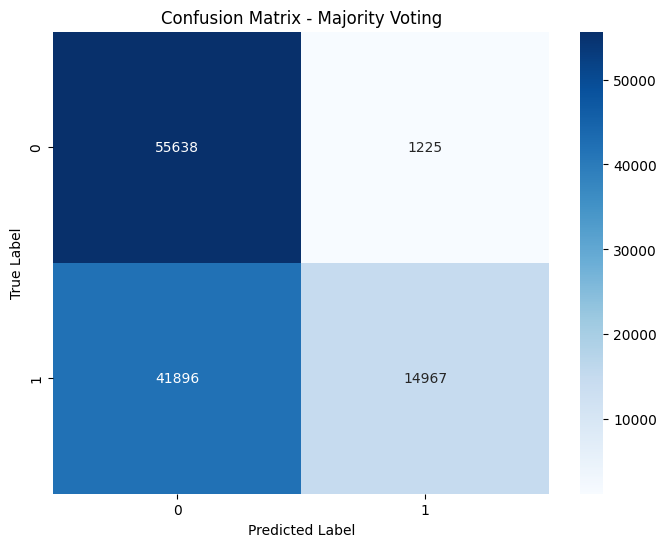


Additional Metrics:
Total cases evaluated: 113726
Predicted fraud cases: 16192
Predicted fraud ratio: 14.24%
Successfully loaded predictions for autoencoder
Successfully loaded predictions for isolation forest
Successfully loaded predictions for LOF


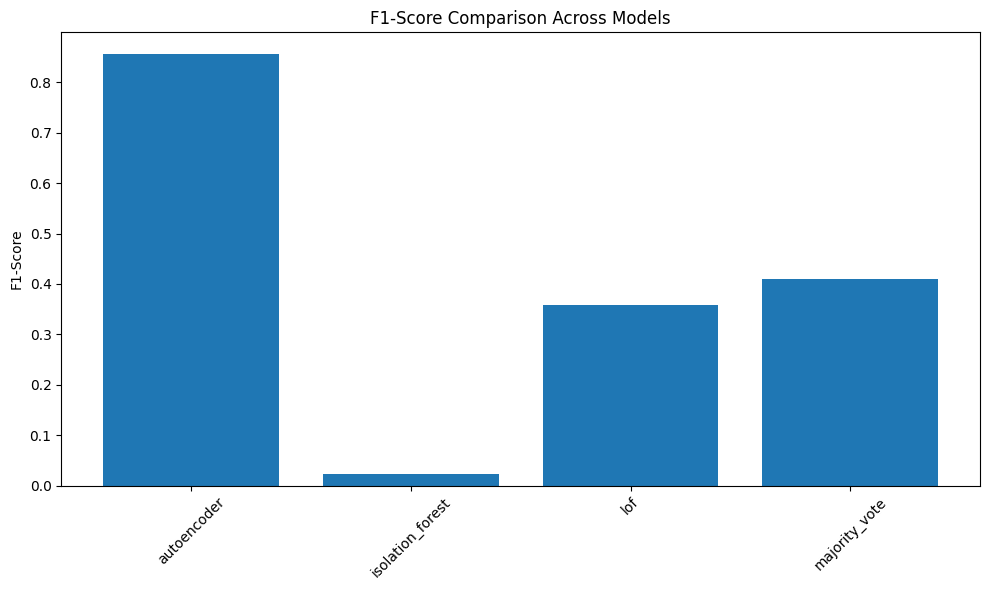


Detailed Model Comparison:
--------------------------------------------------

AUTOENCODER Performance:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     56863
           1       0.96      0.77      0.86     56863

    accuracy                           0.87    113726
   macro avg       0.89      0.87      0.87    113726
weighted avg       0.89      0.87      0.87    113726


ISOLATION_FOREST Performance:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56863
           1       0.93      0.01      0.02     56863

    accuracy                           0.51    113726
   macro avg       0.72      0.51      0.35    113726
weighted avg       0.72      0.51      0.35    113726


LOF Performance:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42     56863
           1       0.38      0.34      0.36     56863

    accuracy                

In [28]:
def perform_majority_vote():
    """
    Load predictions from all models and perform majority voting
    """
    # Initialize framework
    framework = FraudDetectionFramework()
    
    # Load the original test data to get true labels
    _, X_test, _, y_test = framework.load_split_data()
    
    # Get majority vote predictions
    majority_predictions = framework.majority_vote()
    
    # Calculate and display results
    print("\nMajority Voting Results:")
    print("-" * 50)
    print("\nClassification Report:")
    print(classification_report(y_test, majority_predictions))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, majority_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Majority Voting')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate and display additional metrics
    fraud_cases = sum(majority_predictions)
    total_cases = len(majority_predictions)
    
    print("\nAdditional Metrics:")
    print(f"Total cases evaluated: {total_cases}")
    print(f"Predicted fraud cases: {fraud_cases}")
    print(f"Predicted fraud ratio: {fraud_cases/total_cases*100:.2f}%")
    
    return majority_predictions

def compare_model_performances():
    """
    Compare performances of individual models with majority voting
    """
    framework = FraudDetectionFramework()
    _, _, _, y_test = framework.load_split_data()
    
    # Load predictions from each model directly
    predictions = {}
    
    # Load autoencoder predictions
    with open('./results/autoencoder_predictions.pkl', 'rb') as f:
        predictions['autoencoder'] = pickle.load(f)
    print("Successfully loaded predictions for autoencoder")
    
    # Load isolation forest predictions
    with open('./results/isolation_forest_predictions.pkl', 'rb') as f:
        predictions['isolation_forest'] = pickle.load(f)
    print("Successfully loaded predictions for isolation forest")
    
    # Load LOF predictions
    with open('./results/lof_predictions.pkl', 'rb') as f:
        predictions['lof'] = pickle.load(f)
    print("Successfully loaded predictions for LOF")
    
    # Get majority voting predictions
    majority_predictions = framework.majority_vote()
    predictions['majority_vote'] = majority_predictions
    
    # Compare f1-scores
    f1_scores = {}
    for name, preds in predictions.items():
        report = classification_report(y_test, preds, output_dict=True)
        f1_scores[name] = report['1']['f1-score']
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.title('F1-Score Comparison Across Models')
    plt.xticks(rotation=45)
    plt.ylabel('F1-Score')
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Model Comparison:")
    print("-" * 50)
    for name, preds in predictions.items():
        print(f"\n{name.upper()} Performance:")
        print(classification_report(y_test, preds))

if __name__ == "__main__":
    # Perform majority voting
    majority_predictions = perform_majority_vote()
    
    # Compare all models
    compare_model_performances()